<a href="https://colab.research.google.com/github/Clinda02/financial_data_analysis/blob/main/stock/data_collection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 주가 데이터 분석

## 데이터 수집
* [FinanceDataReader](https://github.com/FinanceData/FinanceDataReader#quick-start)

* 지원하는 거래소:
  - KRX(한국거래소),
  - NYSE(뉴욕증권거래소),
  - NASDAQ(나스닥),
  - AMEX(아멕스),
  - SSE(상해),
  - SZSE(심천),
  - HKEX(홍콩),
  - TSE(도쿄)

# 환경세팅

In [4]:
#설치
!pip install finance-datareader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.3/89.3 kB 2.4 MB/s eta 0:00:00


In [20]:
# (라이브러리 설치 후 런타임 재시작 필요)
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (14.8 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 123622 files and direc

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

# 한글 폰트(나눔고딕)을 기본 폰트로 사용하도록 설정
plt.rcParams["font.family"] = 'NanumGothic'

# 그래프에서 마이너스 폰트 깨지는 문제해결
mpl.rcParams['axes.unicode_minus'] = False

## 데이터 수집

In [9]:
import FinanceDataReader as fdr

sp500 = fdr.StockListing('S&P500')
sp500.head(10)

,Symbol,Name,Sector,Industry
0,MMM,3M,Industrials,Industrial Conglomerates
1,AOS,A. O. Smith,Industrials,Building Products
2,ABT,Abbott Laboratories,Health Care,Health Care Equipment
3,ABBV,AbbVie,Health Care,Biotechnology
4,ACN,Accenture,Information Technology,IT Consulting & Other Services
5,ADBE,Adobe Inc.,Information Technology,Application Software
6,AMD,Advanced Micro Devices,Information Technology,Semiconductors
7,AES,AES Corporation,Utilities,Independent Power Producers & Energy Traders
8,AFL,Aflac,Financials,Life & Health Insurance
9,A,Agilent Technologies,Health Care,Life Sciences Tools & Services


In [2]:
import FinanceDataReader as fdr

start_date = "2024-01-01"
end_date = "2024-10-23"
ticker = "005930"

# ticker(종목)에 해당하는 주가 데이터 로딩
df = fdr.DataReader(ticker, start_date, end_date)

# Channge(주가 변화율) 컬럼이 없는 경우, 생성
# 주가 변화율 = 전일 대비 수정종가(Adj Close) 변화량 / 금일 수정종가(Adj Close)
if 'Change' not in df.columns:
    df['Change'] = df['Adj Close'].diff() / df['Adj Close']

# 주가의 질량 = 거래량 / 주가변화율
df['Mass'] = df['Volume'] / ((df['Close']+0.1) * 100) # Close가 0인 경우 대비 +0.1
df['Weight'] = df['Mass'] / 10000

# 거래량 변화량
df['Volume_Change'] = df['Volume'].diff()

- 거래량이 전날 대비 1만 증가하더라도, '거래량 증가'라고 판단하게 됨.
- 책의 저자가 '거래량이 증가했다' 뜻하는 바는 평소 대비 엄청난 거래량(예, 기관, 외국인 등) 이 발생했음을 의미하므로, 다른식으로 거래량이 증가함을 판단해야 함.
- 최근 20일 기준 평균값 대비 금일 거래량이 증가했다면 거래량이 늘어났다고 판단하겠음

In [3]:
df['Volume_Change'] = df['Volume'] - df['Volume'].rolling(20).median()

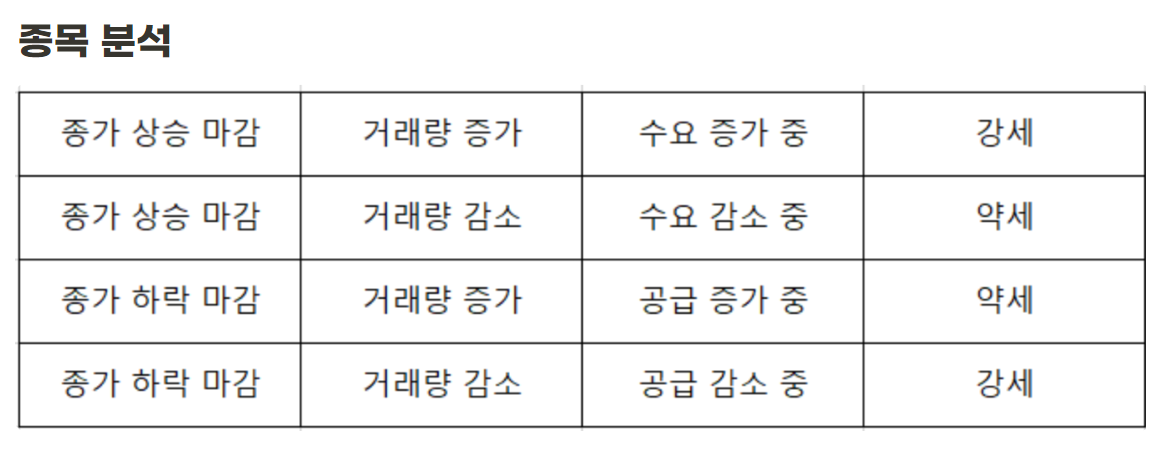

[ToDo] 종가 상승/하락 여부를 시가(Open) (Close)의 단순 수치 비교로 판단했으나, ㅅ시가와 종가의 차이(예. 시가 대비 종가가 n% 증가한 경우를 "상승마감으로, Y%하락한 경우를 "종가 하락 마감"으로 판단)

In [4]:
def get_demand_status(x):
    open, close, volume_change = x['Open'], x['Close'], x['Volume_Change']
    result1, result2 = '', ''
    close_change = close - open
    if close_change > 0 and volume_change > 0:
        result1 = '수요 증가 중'
        result2 = '강세'
    elif close_change > 0 and volume_change <= 0:
        result1 = '수요 감소 중'
        result2 = '약세'
    elif close_change <= 0 and volume_change > 0:
        result1 = '공급 증가 중'
        result2 = '약세'
    elif close_change <= 0 and volume_change <= 0:
        result1 = '공급 감소 중'
        result2 = '강세'
    return result1, result2

In [5]:
# 수요, 강도를 계산하여 신규 컬럼 생성
df['demand'], df['strength'] = zip(*df.apply(get_demand_status, axis=1))

# 2024년 7월 이후의 데이터만 추출
df_sub = df[(df.index.year == 2024) & (df.index.month >= 7)].copy()

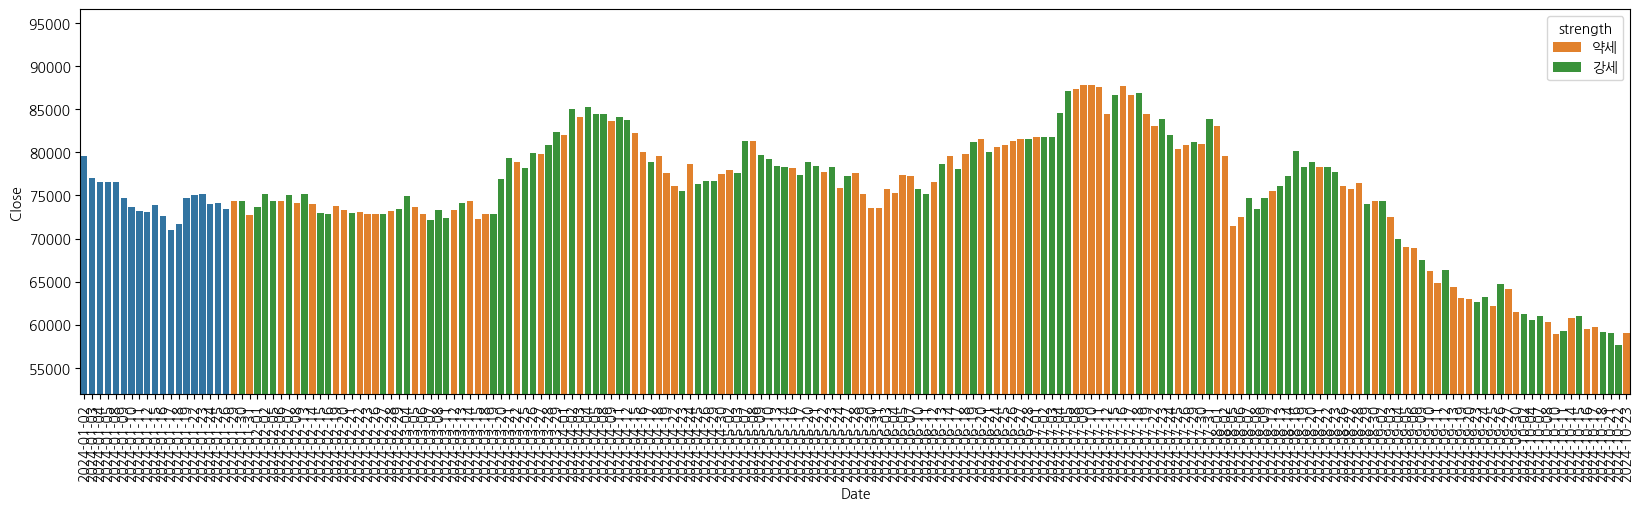

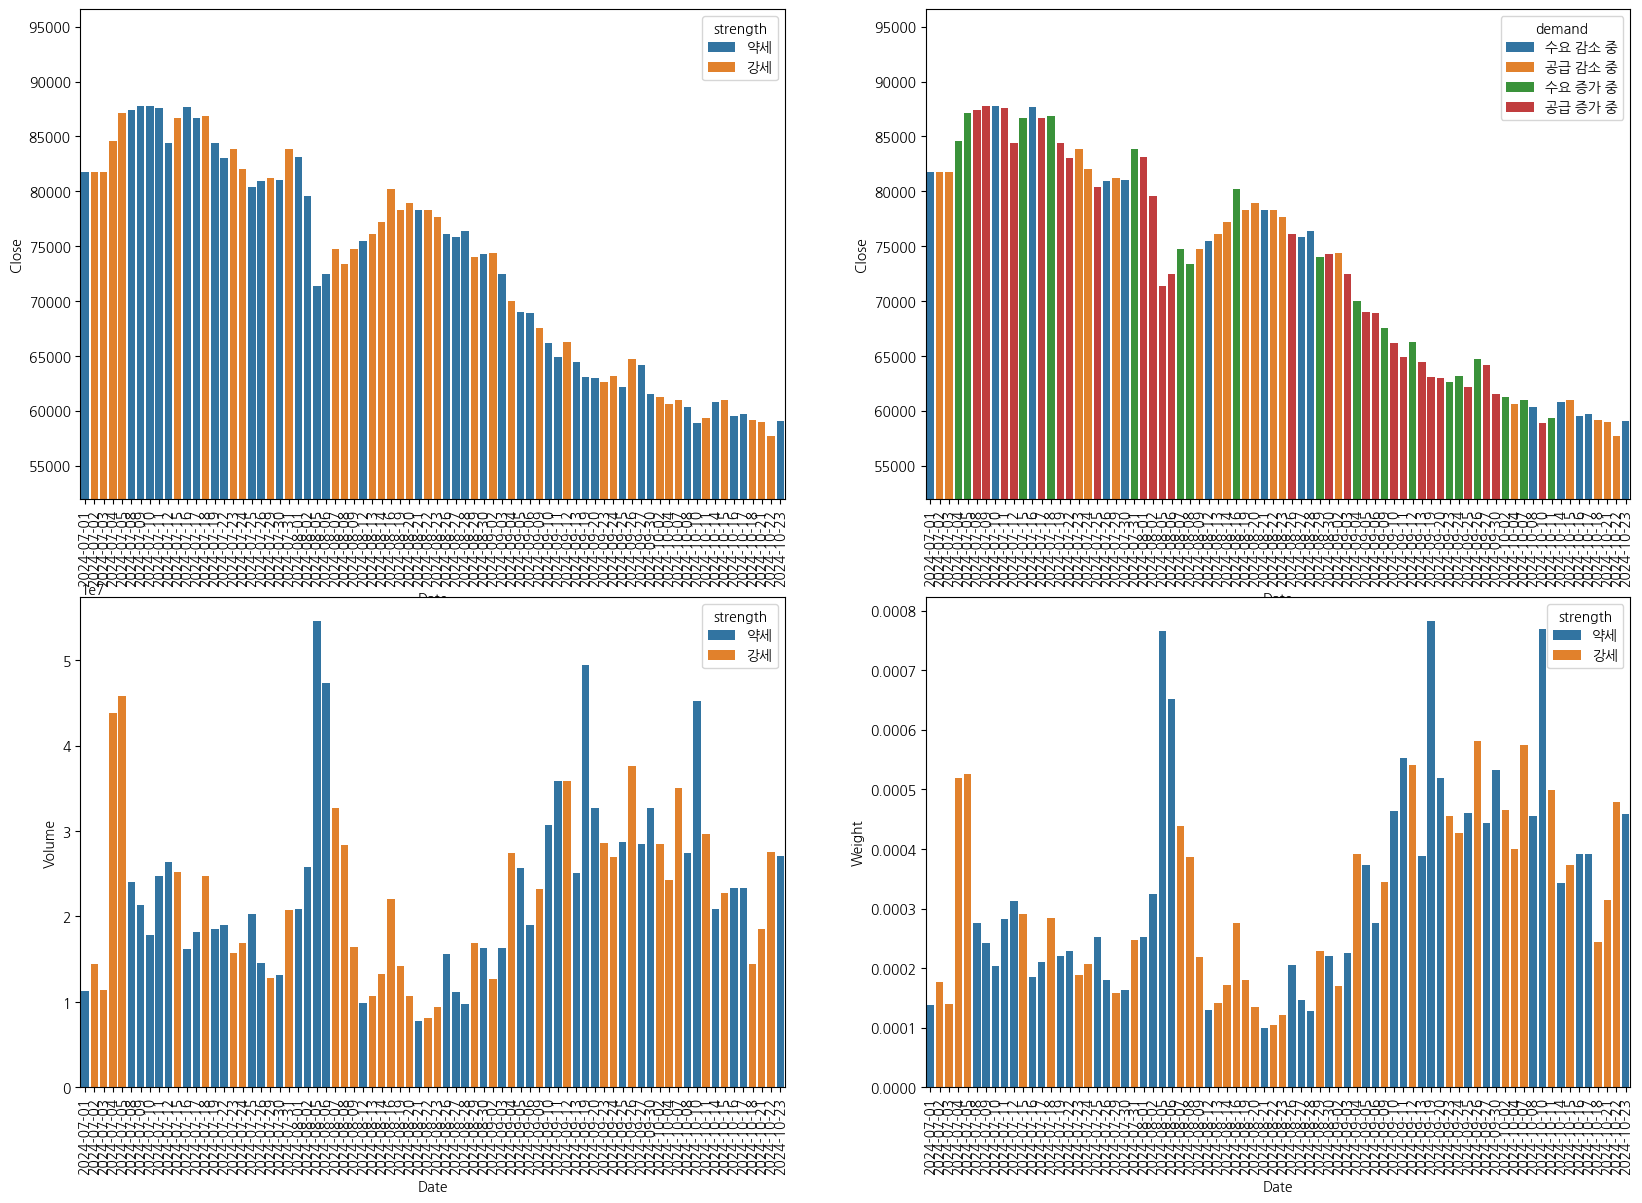

In [6]:
fig, ax = plt.subplots(nrows = 1, ncols=1)
fig.set_size_inches(20,5)

ylim_min = round(df['Close'].min()*0.9, -1)
ylim_max = round(df['Close'].max()*1.1, -1)

plt.subplot(1, 1, 1)
sns.barplot(x= df.index, y = df['Close'], hue = df['strength']).set(ylim=(ylim_min, ylim_max))
plt.xticks(rotation = 90)

fig, ax = plt.subplots(nrows = 2, ncols=2)
fig.set_size_inches(20,14)

ylim_min = round(df_sub['Close'].min()*0.9, -1)
ylim_max = round(df_sub['Close'].max()*1.1, -1)

plt.subplot(2, 2, 1)
sns.barplot(x= df_sub.index, y = df_sub['Close'], hue = df_sub['strength']).set(ylim=(ylim_min, ylim_max))
plt.xticks(rotation = 90)

plt.subplot(2, 2, 2)
sns.barplot(x= df_sub.index, y = df_sub['Close'], hue = df_sub['demand']).set(ylim=(ylim_min, ylim_max))
plt.xticks(rotation = 90)

plt.subplot(2, 2, 3)
sns.barplot(x= df_sub.index, y = df_sub['Volume'], hue = df_sub['strength'])
plt.xticks(rotation = 90)

plt.subplot(2, 2, 4)
sns.barplot(x= df_sub.index, y = df_sub['Weight'], hue = df_sub['strength'])
plt.xticks(rotation = 90)
plt.show()


In [14]:
# 2019년 수익률 1위 : AMD(에이엠디) - 그래픽카드, 집적회로 제조사
amd = fdr.DataReader('AMD', '2019-01-01', '2024-10-23')
amd.head()

,Open,High,Low,Close,Volume,Adj Close
2019-01-02,18.010000,19.000000,17.980000,18.830000,87148700,18.830000
2019-01-03,18.420000,18.680000,16.940001,17.049999,117277600,17.049999
2019-01-04,17.549999,19.070000,17.430000,19.000000,111878600,19.000000
2019-01-07,19.440001,20.680000,19.000000,20.570000,107157000,20.570000
2019-01-08,21.190001,21.200001,19.680000,20.750000,121271000,20.750000


In [19]:
stock_1 =
rise_1 =1685
volume_1 = 5966121
mass_1 = 354072
weight_1 = volume_1 / rise_1

weight_1

3540.7246290801186

In [12]:
import pandas as pd
import numpy as np

주가의 무게 = 거래량 / 주가상승률

amd['change'] = (df['Adj Close'].diff() / df['Adj Close'])

amd['Mass'] = 거래량
amd['Weight'] = amd['Mass'] / (df['Adj Close'].diff() / df['Adj Close'])
amd['demand'] = np.where(if df['close']-df['open'] > 0, 종갓상승, 종가하락)
amd['strength'] = np.where()

In [15]:
!pip install pykrx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.3/254.3 kB 17.5 MB/s eta 0:00:00
